In [1]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 18
df_csv = f"./output/df{year}_pred_lastname.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
lf = (
        pl.scan_csv(
            df_csv,
            has_header=True,
            ignore_errors=True
        )
    )

In [4]:
df = lf.collect(streaming=True)
print(df.head(10))

shape: (10, 22)
┌────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬────────┐
│ dummy1 ┆ dummy2     ┆ contrib_id ┆ name       ┆ … ┆ firstname  ┆ lastname   ┆ name_new  ┆ ethnic │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---    │
│ i64    ┆ i64        ┆ str        ┆ str        ┆   ┆ str        ┆ str        ┆ str       ┆ str    │
╞════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════╡
│ 2018   ┆ 1010320180 ┆ q000074479 ┆ CAZZANI,   ┆ … ┆ serafino v ┆ cazzani    ┆ serafino  ┆ not    │
│        ┆ 036112450  ┆ 2          ┆ SERAFINO V ┆   ┆            ┆            ┆ v cazzani ┆        │
│ 2018   ┆ 1010320180 ┆ p000465054 ┆ JONES,     ┆ … ┆ kenneth    ┆ jones      ┆ kenneth   ┆ not    │
│        ┆ 036112466  ┆ 0          ┆ KENNETH    ┆   ┆            ┆            ┆ jones     ┆        │
│ 2018   ┆ 1010320180 ┆ i300328382 ┆ NARDOLILLO ┆ … ┆ kim        ┆ nardolil

In [5]:
print(df.columns)

['dummy1', 'dummy2', 'contrib_id', 'name', 'recip_id', 'orgname', 'ultorg', 'realcode', 'amount', 'street', 'city', 'state', 'zip', 'recipcode', 'type', 'gender', 'occupation', 'employer', 'firstname', 'lastname', 'name_new', 'ethnic']


In [6]:
print(df["state"].value_counts().sort(by="count", descending=True))

shape: (65, 2)
┌───────┬─────────┐
│ state ┆ count   │
│ ---   ┆ ---     │
│ str   ┆ u32     │
╞═══════╪═════════╡
│ CA    ┆ 2409210 │
│ TX    ┆ 1390237 │
│ NY    ┆ 1235432 │
│ FL    ┆ 787213  │
│ PA    ┆ 713155  │
│ …     ┆ …       │
│ 99    ┆ 48      │
│ MH    ┆ 18      │
│ FM    ┆ 16      │
│ AA    ┆ 9       │
│ PW    ┆ 1       │
└───────┴─────────┘


In [7]:
print(df.filter(pl.col("ethnic") == "ind")["name_new"].value_counts().sort(by="count", descending=True))

shape: (14_061, 2)
┌──────────────────────────────┬───────┐
│ name_new                     ┆ count │
│ ---                          ┆ ---   │
│ str                          ┆ u32   │
╞══════════════════════════════╪═══════╡
│ margaret j reddy             ┆ 1266  │
│ pradyumna chauhan            ┆ 609   │
│ arif khan                    ┆ 460   │
│ iftekhar rahman              ┆ 379   │
│ john langan                  ┆ 314   │
│ …                            ┆ …     │
│ hasna ansari                 ┆ 1     │
│ aravind nemarugommula dr rao ┆ 1     │
│ mandee bhatia                ┆ 1     │
│ varinder dr singh            ┆ 1     │
│ arif rahmam                  ┆ 1     │
└──────────────────────────────┴───────┘


In [ ]:
print(df.filter(pl.col("ethnic") == "not")["amount"].mean())
print(df.filter(pl.col("ethnic") == "ind")["amount"].mean())

356.7072391671521
693.2955820763192


: 

In [ ]:
print(df.filter(pl.col("ethnic") == "not")["amount"].median())
print(df.filter(pl.col("ethnic") == "ind")["amount"].median())

In [ ]:
amounts_all = df["amount"].to_list()
amounts_indian = df.filter(pl.col("ethnic") == "ind")["amount"].to_list()
amounts_non_indian = df.filter(pl.col("ethnic") == "not")["amount"].to_list()

In [11]:
region_mapping = {
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "NJ": "Northeast", "NY": "Northeast", "PA": "Northeast", "RI": "Northeast", "VT": "Northeast",
    
    "IL": "Midwest", "IN": "Midwest", "IA": "Midwest", "KS": "Midwest", "MI": "Midwest",
    "MN": "Midwest", "MO": "Midwest", "NE": "Midwest", "ND": "Midwest", "OH": "Midwest",
    "SD": "Midwest", "WI": "Midwest",
    
    "AL": "South", "AR": "South", "DE": "South", "FL": "South", "GA": "South",
    "KY": "South", "LA": "South", "MD": "South", "MS": "South", "NC": "South",
    "OK": "South", "SC": "South", "TN": "South", "TX": "South", "VA": "South", "WV": "South",
    
    "AK": "West", "AZ": "West", "CA": "West", "CO": "West", "HI": "West",
    "ID": "West", "MT": "West", "NV": "West", "NM": "West", "OR": "West",
    "UT": "West", "WA": "West", "WY": "West"
}

df = df.with_columns(pl.col("state").replace(region_mapping).alias("region"))

In [12]:
census_region_mapping = {
    "CT": "New England", "ME": "New England", "MA": "New England", 
    "NH": "New England", "RI": "New England", "VT": "New England",
    "NJ": "Mid-Atlantic", "NY": "Mid-Atlantic", "PA": "Mid-Atlantic",

    "IL": "Great Lakes", "IN": "Great Lakes", "MI": "Great Lakes", 
    "OH": "Great Lakes", "WI": "Great Lakes",
    "IA": "Plains", "KS": "Plains", "MN": "Plains", 
    "MO": "Plains", "NE": "Plains", "ND": "Plains", "SD": "Plains",

    "DE": "South Atlantic", "FL": "South Atlantic", "GA": "South Atlantic", 
    "MD": "South Atlantic", "NC": "South Atlantic", "SC": "South Atlantic", 
    "VA": "South Atlantic", "WV": "South Atlantic", "DC": "South Atlantic",
    "AL": "Deep South", "KY": "Deep South", "MS": "Deep South", "TN": "Deep South",
    "AR": "Gulf Coast", "LA": "Gulf Coast", "OK": "Gulf Coast", "TX": "Gulf Coast",

    "AZ": "Mountain West", "CO": "Mountain West", "ID": "Mountain West", 
    "MT": "Mountain West", "NV": "Mountain West", "NM": "Mountain West", 
    "UT": "Mountain West", "WY": "Mountain West",
    "AK": "Pacific", "CA": "Pacific", "HI": "Pacific", 
    "OR": "Pacific", "WA": "Pacific"
}

df = df.with_columns(pl.col("state").replace(census_region_mapping).alias("census_region"))

In [13]:
amounts = []
regions = list(dict.fromkeys(region_mapping.values()))

amounts.append(df["amount"].to_list())
for region in regions:
    amounts.append(df.filter(pl.col("region") == region)["amount"].to_list())

In [14]:
census_amounts = []
census_regions = list(dict.fromkeys(census_region_mapping.values()))

census_amounts.append(df["amount"].to_list())
for census_region in census_regions:
    census_amounts.append(df.filter(pl.col("census_region") == census_region)["amount"].to_list())

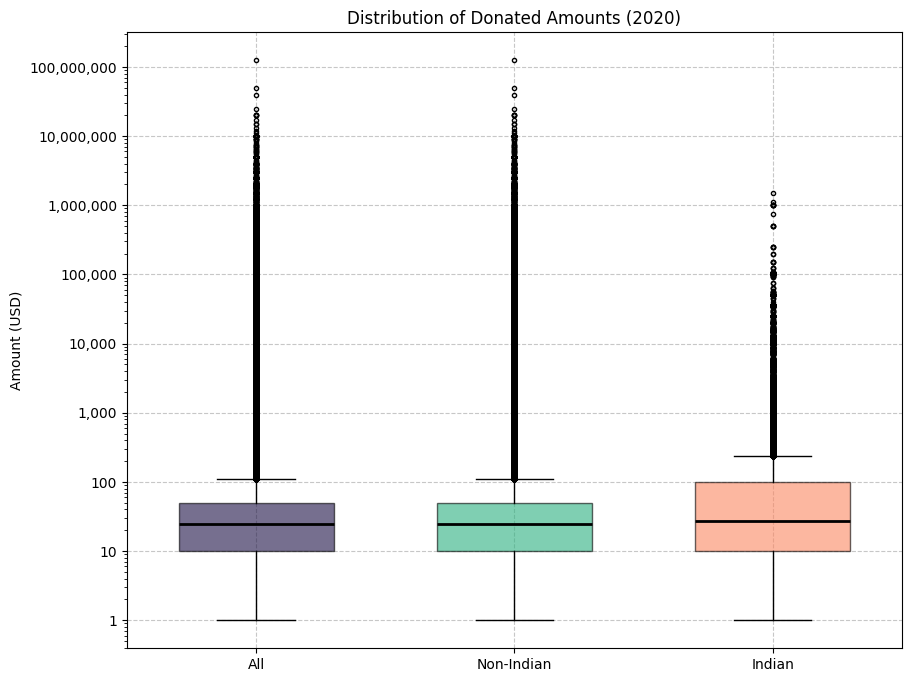

In [15]:
plt.figure(figsize=(10, 8))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], tick_labels=["All", "Non-Indian", "Indian"], patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

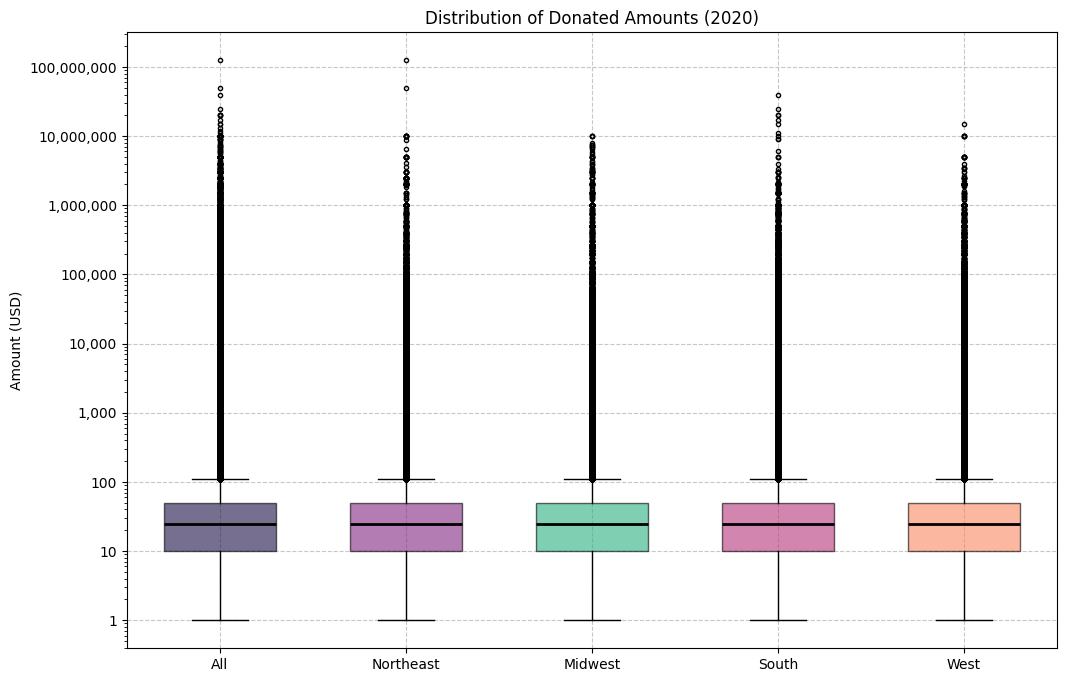

In [16]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(amounts, tick_labels=["All"] + regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#812581", "#2ab07f", "#b5367a", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(census_amounts, tick_labels=["All"] + census_regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#000004", "#1b1044", "#4f127b", "#812581", "#b5367a", "#e55964", "#fb8761", "#fec287", "#fbfdbf", "#fcfffd"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [ ]:
state_stats = (
    lf.collect(streaming=True).group_by("state")
    .agg(
        pl.col("amount").mean().alias("avg_amount"),
        pl.col("amount").median().alias("med_amount"),
        pl.col("amount").count().alias("total_donations"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").mean().alias("avg_amount_indian"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").median().alias("med_amount_indian"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").count().alias("indian_donations")
    )
    .sort("avg_amount", descending=True)
)

In [ ]:
df.filter(pl.col("state") == "TA")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4032820201718323278,"""r0002345953 ""","""YANG, DAVID""","""N00042308""","""Cid Group""",null,"""F2500""",1000.0,null,"""TAIPEI CITY""","""TA""",null,"""DL""","""15E""","""M""","""VENTURE CAPITAL""","""THE CID GROUP""","""david""","""yang""","""david yang""","""not""","""TA""","""TA"""
2020,4032820201718323280,"""r0002345953 ""","""YANG, DAVID""","""N00042308""","""Cid Group""",null,"""F2500""",1000.0,null,"""TAIPEI CITY""","""TA""",null,"""DL""","""15E""","""M""","""VENTURE CAPITAL""","""THE CID GROUP""","""david""","""yang""","""david yang""","""not""","""TA""","""TA"""


In [ ]:
state_stats.sort(by="total_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""PA""",201.065893,37.0,1266349,492.952629,50.0,5383
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916
"""MA""",319.88028,35.0,1138194,664.219606,58.0,5692


In [ ]:
state_stats.write_csv("./output/df20_state_stats.csv")

In [ ]:
import geopandas as gpd

# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats.to_pandas(), on="state", how="left")

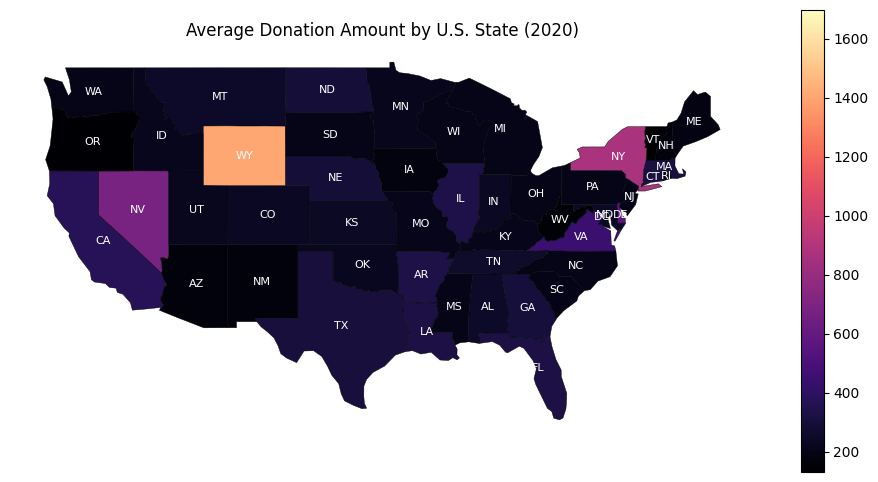

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_stats.sort(by="avg_amount", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""DC""",1696.814094,80.0,474756,262.691786,100.0,4273
"""WY""",1408.825765,50.0,59058,4650.695652,1000.0,46
"""MH""",1166.5,1166.5,2,null,null,0
"""TA""",1000.0,1000.0,2,null,null,0
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""NT""",750.0,750.0,1,null,null,0
"""NV""",678.058047,35.0,322310,3214.073323,250.0,641
"""99""",668.40625,250.0,32,null,null,0
""" """,664.685329,75.0,9502,1981.357143,714.0,56


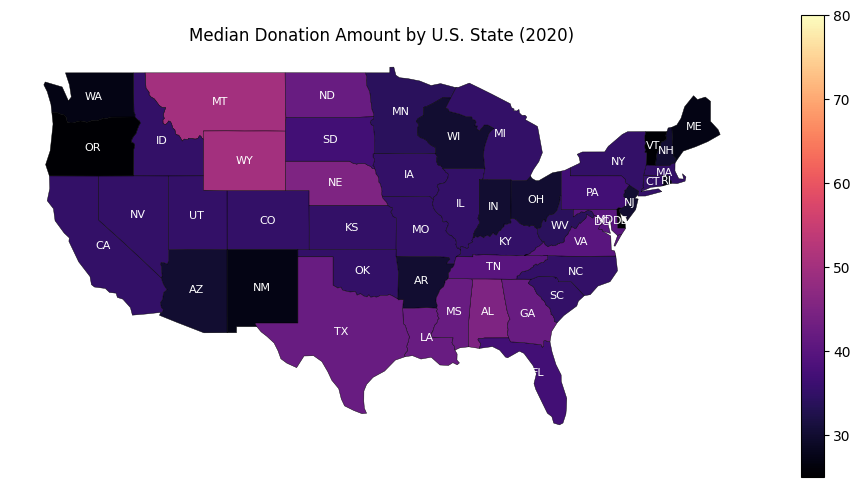

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_stats.sort(by="med_amount", descending=True)[20:30]

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""EN""",202.0,175.0,6,null,null,0
"""HO""",211.4,150.0,5,null,null,0
"""TE""",133.333333,100.0,3,null,null,0
"""TY""",100.0,100.0,2,null,null,0
"""TO""",87.8,100.0,30,null,null,0
"""DC""",1696.814094,80.0,474756,262.691786,100.0,4273
""" """,664.685329,75.0,9502,1981.357143,714.0,56
"""PW""",136.117647,60.0,17,null,null,0
"""WY""",1408.825765,50.0,59058,4650.695652,1000.0,46


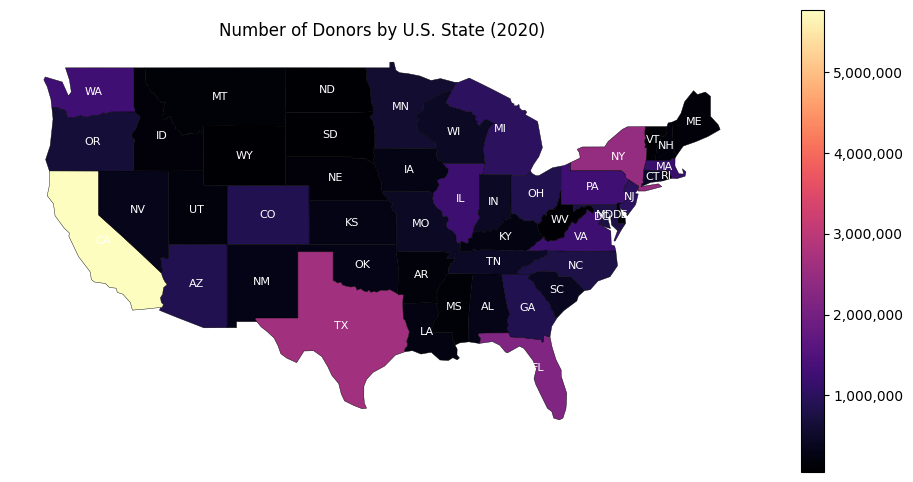

In [ ]:
# import funcformatter


fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="total_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_stats.sort(by="total_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""PA""",201.065893,37.0,1266349,492.952629,50.0,5383
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916
"""MA""",319.88028,35.0,1138194,664.219606,58.0,5692


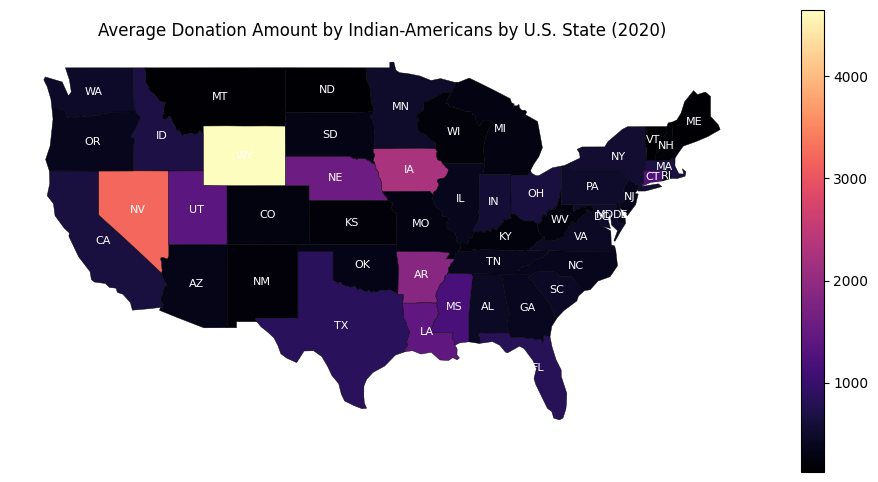

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_stats.sort(by="avg_amount_indian", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""MH""",1166.5,1166.5,2,null,null,0
"""TA""",1000.0,1000.0,2,null,null,0
"""NT""",750.0,750.0,1,null,null,0
"""99""",668.40625,250.0,32,null,null,0
"""IR""",637.162162,500.0,74,null,null,0
"""MB""",578.857143,300.0,7,null,null,0
"""QC""",552.412698,333.0,63,null,null,0
"""FM""",522.333333,437.5,6,null,null,0
"""RM""",500.0,500.0,1,null,null,0


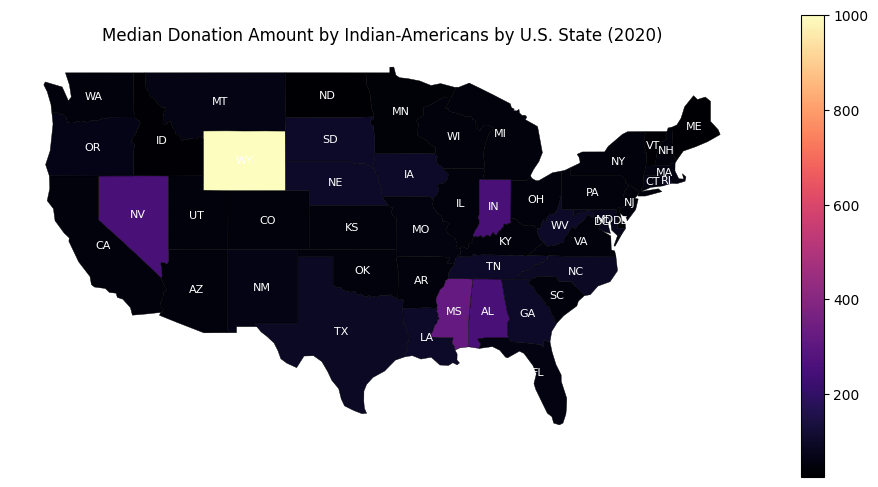

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_stats.sort(by="med_amount_indian", descending=True)[39:49]

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""ON""",344.344828,250.0,290,350.0,350.0,1
"""MS""",199.731586,42.0,129833,1201.137615,314.5,218
"""NV""",678.058047,35.0,322310,3214.073323,250.0,641
"""VI""",349.068306,50.0,3660,165.571429,250.0,21
"""AL""",252.331034,45.0,298329,432.314488,250.0,566
"""IN""",231.419031,30.0,441812,581.054086,250.0,1701
"""RI""",178.555251,27.0,113970,359.623932,103.0,234
"""DC""",1696.814094,80.0,474756,262.691786,100.0,4273
"""LA""",325.451679,42.0,251393,1447.076825,100.0,781


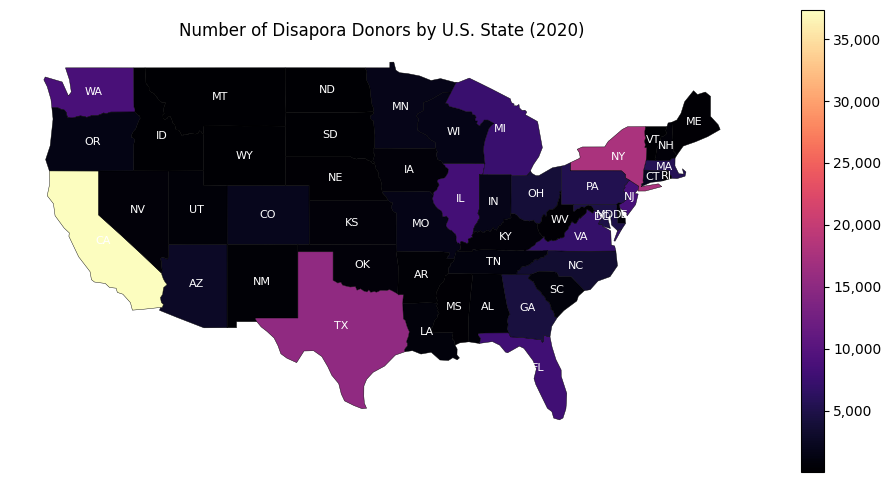

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="indian_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Disapora Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
state_stats.sort(by="indian_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""NJ""",193.451852,30.0,1000117,369.145122,50.0,8517
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""MI""",199.119385,35.0,993046,273.709279,50.0,7361
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916


In [7]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'dummy4', 'dummy5', 'dummy6', 'dummy7', 
                        'dummy8', 'dummy9'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'dummy4', 'dummy5', 'dummy6', 'dummy7', 
                        'dummy8', 'dummy9'])
    )
cands = cands_lf.collect()
print(cands.head(10))

shape: (10, 11)
┌───────────┬───────────┬──────────────────────────┬───────┬───┬────────┬────────┬────────┬────────┐
│ id        ┆ recip_id  ┆ name                     ┆ party ┆ … ┆ dummy6 ┆ dummy7 ┆ dummy8 ┆ dummy9 │
│ ---       ┆ ---       ┆ ---                      ┆ ---   ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str       ┆ str       ┆ str                      ┆ str   ┆   ┆ str    ┆ str    ┆ str    ┆ str    │
╞═══════════╪═══════════╪══════════════════════════╪═══════╪═══╪════════╪════════╪════════╪════════╡
│ H0AL02087 ┆ N00030768 ┆ Martha Roby (R)          ┆ R     ┆ … ┆ Y      ┆ I      ┆ RW     ┆        │
│ H0AL03192 ┆ N00043592 ┆ Hannah Thompson (D)      ┆ D     ┆ … ┆        ┆        ┆ DN     ┆        │
│ H0AL05049 ┆ N00003042 ┆ Bud Cramer (D)           ┆ D     ┆ … ┆        ┆        ┆ DN     ┆        │
│ H0AL05163 ┆ N00030910 ┆ Mo Brooks (R)            ┆ R     ┆ … ┆ Y      ┆ I      ┆ RW     ┆        │
│ H0AL06088 ┆ N00030911 ┆ Stanley Kyle Cooke (R)   ┆ R     ┆ … ┆        ┆  

In [8]:
df.filter(pl.col("recip_id") == "N00030768").head(5)

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic
i64,i64,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str
2018,4020220181503742094,"""a0000020252@""","""ARONOV, LOREE RENEE""","""N00030768""","""Aronov Realty Co""","""""","""F4000""",2700.0,"""""","""MONTGOMERY""","""AL""",36111,"""RW""","""15 ""","""F""","""HOMEMAKER""","""NONE""","""loree renee""","""aronov""","""loree renee aronov""","""not"""
2018,4020220181503742105,"""q0002961393 ""","""BROWN, MARY MCCALEB""","""N00030768""","""Retired""","""""","""X1200""",500.0,"""""","""MONTGOMERY""","""AL""",36106,"""RW""","""15 ""","""F""","""""","""""","""mary mccaleb""","""brown""","""mary mccaleb brown""","""not"""
2018,4020220181503742111,"""n0001186317 ""","""COOLEY, THOMAS E MR""","""N00030768""","""Columbia Southern University""","""Columbia Southern Education Gr…","""H5300""",1000.0,"""""","""ELBERTA""","""AL""",36530,"""RW""","""15 ""","""M""","""""","""""","""thomas e mr""","""cooley""","""thomas e mr cooley""","""not"""
2018,4020220181503742112,"""e1120112775 ""","""DAVIS, GEOFFREY C MR""","""N00030768""","""Republic Consulting""","""""","""K2000""",500.0,"""""","""HEBRON""","""KY""",41048,"""RW""","""15 ""","""M""","""CONSULTANT""","""REPUBLIC CONSULTING LLC""","""geoffrey c mr""","""davis""","""geoffrey c mr davis""","""not"""
2018,4020220181503742116,"""j1001966314 ""","""EDWARDS, CHARLES W MR JR""","""N00030768""","""Edwards Plumbing & Parts""","""""","""B3400""",250.0,"""""","""MONTGOMERY""","""AL""",36117,"""RW""","""15 ""","""M""","""PLUMBER""","""EDWARDS PLUMBING AND PARTS""","""charles w mr jr""","""edwards""","""charles w mr jr edwards""","""not"""


In [9]:
recipients_indian_dons = df.filter(pl.col("ethnic") == "ind")["recip_id"].to_list()
cands_indian_donors = cands.filter(pl.col("recip_id").is_in(recipients_indian_dons))
cands_indian_donors.head(5)

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9
str,str,str,str,str,str,str,str,str,str,str
"""H0AL02087""","""N00030768""","""Martha Roby (R)""","""R""","""AL02""","""AL02""","""Y""","""Y""","""I""","""RW""",""" """
"""H0AL05163""","""N00030910""","""Mo Brooks (R)""","""R""","""AL05""","""AL05""","""Y""","""Y""","""I""","""RW""",""" """
"""H0AL07086""","""N00030622""","""Terri A Sewell (D)""","""D""","""AL07""","""AL07""","""Y""","""Y""","""I""","""DW""",""" """
"""H0AR01083""","""N00030770""","""Rick Crawford (R)""","""R""","""AR01""","""AR01""","""Y""","""Y""","""I""","""RW""",""" """
"""H0AR03055""","""N00031857""","""Steve Womack (R)""","""R""","""AR03""","""AR03""","""Y""","""Y""","""I""","""RW""",""" """


In [10]:
cands_indian_donors["party"].value_counts().sort(by="count", descending=True)

party,count
str,u32
"""D""",706
"""R""",453
"""I""",11
"""L""",4
"""3""",3


In [11]:
cands_indian_donors["dummy8"].value_counts().sort(by="count", descending=True)

dummy8,count
str,u32
"""DL""",353
"""DW""",246
"""RL""",189
"""RW""",187
"""DN""",72
…,…
"""3L""",13
"""3W""",3
"""3N""",2


In [12]:
donations = (
    df.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"),
         pl.count("amount").alias("num_donations"))
)

receipts = cands.join(donations, on="recip_id", how="left").fill_null(0)
receipts = receipts.sort("total_amount", descending=True)
receipts[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations
str,str,str,str,str,str,str,str,str,str,str,f64,u32
"""S8FL00273""","""N00043290""","""Rick Scott (R)""","""R""","""FLS1""",""" ""","""Y""","""Y""","""C""","""RW""",""" """,8.7427945e7,20941
"""H2TX16185""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""",""" """,""" """,""" ""","""C""","""DL""",""" """,6.3951686e7,297862
"""S8TX00285""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""","""TX16""","""Y""","""Y""","""C""","""DL""","""Y""",6.3951686e7,297862
"""S6MO00305""","""N00027694""","""Claire McCaskill (D)""","""D""","""MOS2""","""MOS2""","""Y""","""Y""","""I""","""DL""",""" """,4.570206e7,147549
"""H6NV03139""","""N00038734""","""Jacky Rosen (D)""","""D""","""NVS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,2.7239475e7,100838
"""S8NV00156""","""N00038734""","""Jacky Rosen (D)""","""D""","""NVS1""","""NV03""","""Y""","""Y""","""C""","""DW""",""" """,2.7239475e7,100838
"""S8FL00166""","""N00009926""","""Bill Nelson (D)""","""D""","""FLS1""","""FLS1""","""Y""","""Y""","""I""","""DL""",""" """,2.6347529e7,91719
"""S2ND00099""","""N00033782""","""Heidi Heitkamp (D)""","""D""","""NDS2""","""NDS2""","""Y""","""Y""","""I""","""DL""",""" """,2.5343279e7,70680
"""P60006111""","""N00033085""","""Ted Cruz (R)""","""R""","""TXS2""",""" """,""" """,""" ""","""I""","""RW""",""" """,2.5334071e7,146326


In [13]:
df_indian = df.filter(pl.col("ethnic") == "ind")

donations_indian = (
    df_indian.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"),
         pl.count("amount").alias("num_donations"))
)

receipts_indian = cands.join(donations_indian, on="recip_id", how="left").fill_null(0)
receipts_indian = receipts_indian.sort("total_amount", descending=True)
receipts_indian[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations
str,str,str,str,str,str,str,str,str,str,str,f64,u32
"""S8MA00268""","""N00041034""","""Shiva Ayyadurai (I)""","""I""","""MAS1""",""" ""","""Y""","""Y""","""C""","""3L""",""" """,4.825763e6,42
"""H8NY12129""","""N00041983""","""Suraj Patel (D)""","""D""","""NY12""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.757948e6,941
"""H6IL08147""","""N00033240""","""Raja Krishnamoorthi (D)""","""D""","""IL08""","""IL08""","""Y""","""Y""","""I""","""DW""",""" """,1.090927e6,1222
"""H8TX29086""","""N00042285""","""Tahir Javed (D)""","""D""","""TX29""",""" """,""" ""","""Y""","""O""","""DL""",""" """,741016.0,129
"""H2TX16185""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""",""" """,""" """,""" ""","""C""","""DL""",""" """,536476.0,1716
"""S8TX00285""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""","""TX16""","""Y""","""Y""","""C""","""DL""","""Y""",536476.0,1716
"""H4CA12055""","""N00026427""","""Ro Khanna (D)""","""D""","""CA17""","""CA17""","""Y""","""Y""","""I""","""DW""","""Y""",507647.0,326
"""H8MA22015""","""N00042142""","""Sri Kulkarni (D)""","""D""","""TX22""",""" """,""" """,""" ""","""C""","""DL""",""" """,479455.0,556
"""H8TX22289""","""N00042142""","""Sri Kulkarni (D)""","""D""","""TX22""",""" ""","""Y""","""Y""","""C""","""DL""",""" """,479455.0,556


In [14]:
print(receipts["total_amount"].sum())
print(receipts_indian["total_amount"].sum())

2511935884.0
34353464.0


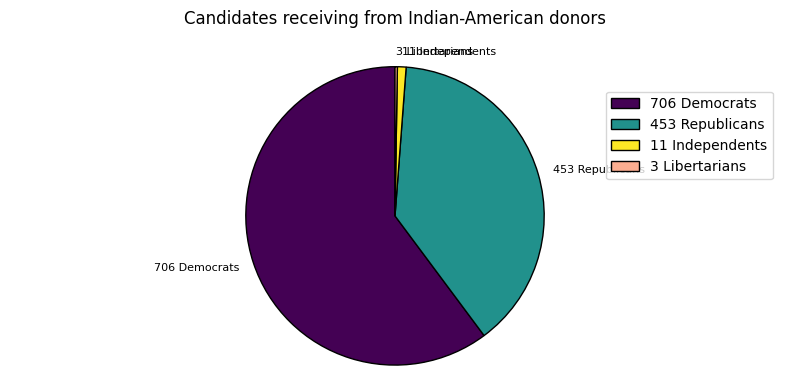

In [21]:
labels = ['706 Democrats', '453 Republicans', '11 Independents', '3 Libertarians']
sizes = [706, 453, 11, 3]

plt.figure(figsize=(8, 4))
plt.pie(sizes, 
        labels=labels, 
        colors=["#440154", "#21918c", "#fde725", "#fcae91"],
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 8})

plt.title('Candidates receiving from Indian-American donors', pad=20, fontsize=12)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

In [16]:
receipts_merged = receipts_indian.join(
    receipts.select(["recip_id", "total_amount"]),
    on="recip_id",
    how="inner"
)

receipts_merged = receipts_merged.with_columns(
    (pl.col("total_amount") / 
    pl.col("total_amount_right") * 100)
    .alias("pct_share")
)

receipts_merged.head(10)

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""S8FL00273""","""N00043290""","""Rick Scott (R)""","""R""","""FLS1""",""" ""","""Y""","""Y""","""C""","""RW""",""" """,140450.0,89,8.7427945e7,0.160647
"""H2TX16185""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""",""" """,""" """,""" ""","""C""","""DL""",""" """,536476.0,1716,6.3951686e7,0.838877
"""S8TX00285""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""","""TX16""","""Y""","""Y""","""C""","""DL""","""Y""",536476.0,1716,6.3951686e7,0.838877
"""H2TX16185""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""",""" """,""" """,""" ""","""C""","""DL""",""" """,536476.0,1716,6.3951686e7,0.838877
"""S8TX00285""","""N00033540""","""Beto O'Rourke (D)""","""D""","""TXS2""","""TX16""","""Y""","""Y""","""C""","""DL""","""Y""",536476.0,1716,6.3951686e7,0.838877
"""S6MO00305""","""N00027694""","""Claire McCaskill (D)""","""D""","""MOS2""","""MOS2""","""Y""","""Y""","""I""","""DL""",""" """,293790.0,647,4.570206e7,0.642838
"""H6NV03139""","""N00038734""","""Jacky Rosen (D)""","""D""","""NVS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,250349.0,579,2.7239475e7,0.919067
"""S8NV00156""","""N00038734""","""Jacky Rosen (D)""","""D""","""NVS1""","""NV03""","""Y""","""Y""","""C""","""DW""",""" """,250349.0,579,2.7239475e7,0.919067
"""H6NV03139""","""N00038734""","""Jacky Rosen (D)""","""D""","""NVS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,250349.0,579,2.7239475e7,0.919067


In [17]:
top_shares = receipts_merged.filter((pl.col("pct_share").is_not_null()) & 
                        (pl.col("pct_share").is_not_nan())
    ).sort(
    pl.col("pct_share"), 
    descending=True
)
top_shares[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""H6AZ01181""","""N00013843""","""Miguel Olivas (D)""","""D""","""AZ01""",""" """,""" """,""" """,""" ""","""DN""",""" """,1000.0,1,1000.0,100.0
"""H0KS04077""","""N00030933""","""Raj Goyle (D)""","""D""","""KS04""",""" """,""" """,""" """,""" ""","""DN""",""" """,750.0,5,750.0,100.0
"""S8MA00268""","""N00041034""","""Shiva Ayyadurai (I)""","""I""","""MAS1""",""" ""","""Y""","""Y""","""C""","""3L""",""" """,4.825763e6,42,4.955184e6,97.38817
"""H8TX02158""","""N00042223""","""Silky Malik (D)""","""D""","""TX02""",""" """,""" ""","""Y""","""O""","""DL""",""" """,9104.0,8,11571.0,78.679457
"""H8NY12129""","""N00041983""","""Suraj Patel (D)""","""D""","""NY12""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.757948e6,941,2.253296e6,78.016736
"""H8IL08119""","""N00042119""","""Vandana Jhingan (R)""","""R""","""IL08""",""" """,""" ""","""Y""","""C""","""RN""",""" """,46100.0,20,62400.0,73.878205
"""H8IL08101""","""N00042118""","""Jitendra Diganvker (R)""","""R""","""IL08""",""" ""","""Y""","""Y""","""C""","""RL""",""" """,34905.0,42,51919.0,67.229723
"""H8CT04214""","""N00042089""","""Harry Arora (R)""","""R""","""CT04""",""" ""","""Y""","""Y""","""C""","""RL""",""" """,318950.0,34,490721.0,64.996199
"""H8CA48084""","""N00041312""","""Omar Siddiqui (D)""","""D""","""CA48""",""" """,""" ""","""Y""","""C""","""DL""",""" """,318619.0,68,528852.0,60.24729


In [20]:
top_shares[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""H6AZ01181""","""N00013843""","""Miguel Olivas (D)""","""D""","""AZ01""",""" """,""" """,""" """,""" ""","""DN""",""" """,1000.0,1,1000.0,100.0
"""H0KS04077""","""N00030933""","""Raj Goyle (D)""","""D""","""KS04""",""" """,""" """,""" """,""" ""","""DN""",""" """,750.0,5,750.0,100.0
"""S8MA00268""","""N00041034""","""Shiva Ayyadurai (I)""","""I""","""MAS1""",""" ""","""Y""","""Y""","""C""","""3L""",""" """,4.825763e6,42,4.955184e6,97.38817
"""H8TX02158""","""N00042223""","""Silky Malik (D)""","""D""","""TX02""",""" """,""" ""","""Y""","""O""","""DL""",""" """,9104.0,8,11571.0,78.679457
"""H8NY12129""","""N00041983""","""Suraj Patel (D)""","""D""","""NY12""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.757948e6,941,2.253296e6,78.016736
"""H8IL08119""","""N00042119""","""Vandana Jhingan (R)""","""R""","""IL08""",""" """,""" ""","""Y""","""C""","""RN""",""" """,46100.0,20,62400.0,73.878205
"""H8IL08101""","""N00042118""","""Jitendra Diganvker (R)""","""R""","""IL08""",""" ""","""Y""","""Y""","""C""","""RL""",""" """,34905.0,42,51919.0,67.229723
"""H8CT04214""","""N00042089""","""Harry Arora (R)""","""R""","""CT04""",""" ""","""Y""","""Y""","""C""","""RL""",""" """,318950.0,34,490721.0,64.996199
"""H8CA48084""","""N00041312""","""Omar Siddiqui (D)""","""D""","""CA48""",""" """,""" ""","""Y""","""C""","""DL""",""" """,318619.0,68,528852.0,60.24729


In [19]:
df.filter(pl.col("recip_id") == "N00009954")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic
i64,i64,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str
